In [1]:
#imports 
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estammos usando: {device}')



Estammos usando: cpu


## Supernova parametric model (SPM)

Existen 4 tipos de supernovas: SNIbc, SNIa, SNII, SLSN

In [2]:
def SPM(t, A, t_0, t_1, B, t_rise, t_fall):
    gamma = t_1 - t_0
    s = 0.2
    F = []
    
    for t_i in t:
        # g(t)
        arg = s*(t_i-(gamma+t_0))
        g = 1/(1 + np.exp(- arg))
        
        # F_early and F_late
        x_early = A*(1-B*((t_i-t_0)/gamma))
        x_late = (A*(1-B)*np.exp(gamma/t_fall))
        y = (1+np.exp(-(t_i-t_0)/t_rise))
        
        F_early = x_early/y
        F_late = x_late/y
        
        #F_sne
        F_i = F_early*(1-g) + F_late*g
        F.append(F_i)
        
    return torch.FloatTensor(F)

In [3]:
# parameters

#Amplitud: cerca de 20
#t0: timpo inicial
#t_1: tiempo en que empieza a transisionar la SN
#gamma: controls the time duration of the SN-plateau region
#beta: controls the slope of the SN-plateau region (pendiente)
#t_rise: controls the required time to reach the maximum brightness along the light-curve
#t_fall: controls the brightness decay time along and after the SN-plateau region

A = 50
t_0 = 58600
t_1 = 58640
B = 0.8
t_rise = 25
t_fall = 50


100


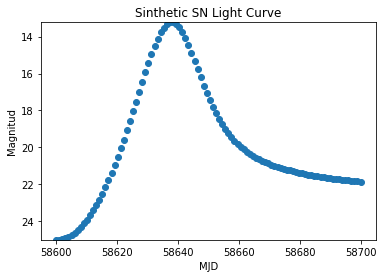

In [12]:
t = np.linspace(58600,58700,100)
F = SPM(t, A, t_0, t_1, B, t_rise, t_fall)
print(len(F))

plt.plot(t, F, 'o')
plt.title("Sinthetic SN Light Curve")
plt.xlabel("MJD")
plt.ylabel("Magnitud")
plt.ylim(max(F),min(F))
plt.show()

In [17]:
x = np.log(F)
W_1 = nn.Linear(len(x), 128, bias = False)

W_1(x).size()


torch.Size([128])

## Create Minibatches

In [8]:
def create_minibatches(x, y, mb_size, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Accuracy

In [9]:
def accuracy(model, x, y, mb_size):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

            return float(num_correct)/num_total     

## Training Loop

In [10]:
def train(model, optimiser, mb_size, epochs=100):
    #model = model.to(device=device)
    for epoch in range(epochs):
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # funcion cost
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {accuracy(model, x_val_tensor, y_val_tensor, mb_size)}')

In [23]:
a = torch.randn(4, 28)
a

tensor([[-0.2256,  2.8188,  0.6179, -0.1532,  0.1235,  0.5674,  2.5628,  0.3329,
          0.1541,  0.4232, -1.2192,  0.0239,  0.4308,  0.1289, -0.1680, -1.0334,
         -0.0432, -0.2275,  1.0634,  0.4170, -0.4445, -1.0166, -0.8077, -0.8633,
         -0.5319, -0.4032,  0.4792, -3.8854],
        [-0.2213,  0.0317, -1.0151, -1.2007,  0.7171, -0.6053,  0.1991, -1.7216,
         -1.0401, -1.7839,  1.3698,  1.3650,  1.2147, -1.1951,  0.3211,  0.8493,
         -0.2478,  0.4440,  0.8346, -1.2845, -2.4780, -0.2601,  3.0309,  0.2398,
          1.3373, -0.5441,  0.3223, -0.2757],
        [ 0.2700, -0.0576,  0.5524,  0.8057, -0.1558,  0.1135,  0.0772, -0.4102,
          1.2137, -0.6619, -0.4821,  0.5611,  1.1236, -1.3540, -0.0053, -0.3551,
         -0.3989,  1.0333, -1.5751,  0.6884, -0.5721,  0.5360, -2.4673, -0.1842,
          0.7127,  1.2115,  0.5168, -0.1205],
        [ 0.0196, -0.8997, -2.1792,  0.3257,  0.3281,  0.7582,  0.0124, -0.7458,
          3.5758,  0.3145, -2.0412, -1.1988,  1.1486

## Custom Layer

In [20]:
class TimeFILM(nn.Module):
    def __init__(self, size_in, M, t): #size_in sería 128 o L x 128????
        super().__init__()
        self.size_in= size_in
        self.t = t
        self.M = M
        T = torch.Tensor(size_in)
        a = torch.Tensor(M, size_in)
        b = torch.Tensor(M, size_in)
        v = torch.Tensor(M, size_in)
        w = torch.Tensor(M, size_in)
        self.a = nn.Parameter(a)  # nn.Parameter is a Tensor that's a module parameter.
        self.b = nn.Parameter(b)
        self.v = nn.Parameter(v)
        self.w = nn.Parameter(w)
     
        
        # initialize weights and biases
        torch.nn.init.normal_(self.a, mean=0.0, std=1.0)
        torch.nn.init.normal_(self.b, mean=0.0, std=1.0)
        torch.nn.init.normal_(self.v, mean=0.0, std=1.0)
        torch.nn.init.normal_(self.w, mean=0.0, std=1.0)
        
        
    def forward(self, x):
        gamma = torch.sum(self.a*torch.sin((2*torch.pi*self.M)*self.T/(1.5*self.t)) + self.b*torch.cos((2*torch.pi*self.M)*self.T/(1.5*self.t)), 1)
        beta =  torch.sum(self.v*torch.sin((2*torch.pi*self.M)*self.T/(1.5*self.t)) + self.w*torch.cos((2*torch.pi*self.M)*self.T/(1.5*self.t)), 1)
            
        x_out = torch.nn.Tanh(gamma * x + beta)
        return x_out



## Serial Encoder

In [ ]:
#Instanciar modelo
size_in = 128 
M = 4
L = 100
lr = 5e-2
epochs = 100
mb_size = 4096
model1 = nn.Sequential(nn.Linear(in_features=L, out_features=size_in),
                       TimeFILM(size_in, M, L),
                       nn.Linear(in_features=, out_features=), nn.ReLU(),
                       nn.MultiheadAttention(embed_dim, num_heads), # No sabemos bien las dimensiones de embed_dim (son Lx128??)
                       ##falta la capa en que se saca el ultimo vector z (como se podría implementar??)
                      )
                       
                       
optimiser = torch.optim.SGD(model1.parameters(), lr=lr)
train(model1, optimiser, mb_size, epochs)